In [63]:
#setup

%load_ext autoreload
%autoreload 2

import random
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


import sys


# add /Users/ywxiu/jasp-multimodal-rag/src to sys.path
project_root = Path.cwd().parent  # goes from notebooks → jasp-multimodal-rag
src_path = project_root / "src"
sys.path.append(str(src_path))

import retrieval.retrieval as retr  # adjust if needed


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
#Step 1 – Load test_set
TEST_JSON = Path("/Users/ywxiu/jasp-multimodal-rag/data/test_QA/QA_filled_1.json")

with open(TEST_JSON, "r") as f:
    test_set = json.load(f)


print(list(test_set[0]))
len(test_set)

['id', 'query', 'answerable', 'ground_truth_answer', 'relevant_chunk_ids']


12

In [ ]:
#Step 2 – Helper to apply a config to the retrieval module
def apply_config(cfg: dict):
    retr.K_BM25        = cfg["K_BM25"]
    retr.BOOST_WEIGHT  = cfg["boost_weight"]
    retr.K_SEMANTIC    = cfg["K_SEMANTIC"]
    retr.RRF_K         = cfg["RRF_K"]
    retr.TOP_AFTER_RRF = cfg["TOP_AFTER_RRF"]
    retr.SCORE_THRESHOLD = cfg["score_threshold"]
    retr.TOP_FINAL     = cfg["TOP_FINAL"]


In [ ]:
#Step 3 – Evaluation function (compute H1a, H1b, H2)

def evaluate_config(cfg: dict, test_set: list):
    """Run retrieval for a given config and compute H1a, H1b, H2."""
    apply_config(cfg)

    retrieval_results = []

    for item in test_set:
        q = item["query"]
        qid = item["id"]
        relevant_ids = set(item["relevant_chunk_ids"])

        # Run your pipeline
        results = retr.retrieve_top_k(q, top_k=cfg["TOP_FINAL"])

        retrieved_ids = [
            # try doc_id, fall back to section_id
            (getattr(r, "metadata", {}) or {}).get("doc_id")
            or (getattr(r, "metadata", {}) or {}).get("section_id")
            for r in results
        ]

        success_at_k = any(rid in relevant_ids for rid in retrieved_ids[:cfg["TOP_FINAL"]])
        top1_relevant = retrieved_ids[0] in relevant_ids if retrieved_ids else False

        retrieval_results.append({
            "id": qid,
            "query": q,
            "answerable": item["answerable"],
            "retrieved_ids": retrieved_ids,
            "success_at_k": success_at_k,
            "top1_relevant": top1_relevant,
        })

    df = pd.DataFrame(retrieval_results)
    df_answerable   = df[df["answerable"] == True]
    df_unanswerable = df[df["answerable"] == False]

    H1a = df_answerable["success_at_k"].mean() if not df_answerable.empty else float("nan")
    H1b = df_answerable["top1_relevant"].mean() if not df_answerable.empty else float("nan")

    if not df_unanswerable.empty:
        is_empty = (df_unanswerable["retrieved_ids"].str.len() == 0)
        H2 = is_empty.mean()
    else:
        H2 = float("nan")

    return H1a, H1b, H2


In [ ]:
#Step 4 – run Evaluation function across all parameter combinations(compute H1a, H1b, H2)

from itertools import product
from tqdm import tqdm
import pandas as pd

def run_full_grid_search(param_space, test_set, save_path=None):
    """
    Run a full grid search over all parameter combinations.

    param_space: dict of parameter -> list of values
    test_set: your loaded QA dataset
    save_path: optional path to save CSV
    """
    # Convert dict to list of (name, values)
    param_items = list(param_space.items())

    # Build all combinations
    configs = []
    for values in product(*[vals for _, vals in param_items]):
        cfg = {param_items[i][0]: values[i] for i in range(len(values))}
        configs.append(cfg)

    print(f"Total combinations: {len(configs)}")

    results = []

    # Evaluate all configs with progress bar
    for cfg in tqdm(configs, desc="Grid Search"):
        H1a, H1b, H2 = evaluate_config(cfg, test_set)

        results.append({
            **cfg,
            "H1a": H1a,
            "H1b": H1b,
            "H2": H2
        })

    df_results = pd.DataFrame(results)

    # Optionally save a CSV
    if save_path:
        df_results.to_csv(save_path, index=False)
        print(f"Saved results to {save_path}")

    return df_results


In [75]:
#Step 5 – Parameter space for tuning
param_space = {
    "K_BM25":          [3, 5, 10],
    "K_SEMANTIC":      [3, 5, 10],
    "RRF_K":           [60, 80, 120],
    "TOP_AFTER_RRF":   [3, 5, 10],
    "TOP_FINAL":       [1, 3, 5],
    "score_threshold": [-3, -2,-1, -0.5, 0, 0.5, 1, 1.5, 2.0],
    "boost_weight":    [0.0, 1.0, 3.0, 4.0,5.0],

}


from itertools import product

print("Current param_space:")
for k, v in param_space.items():
    print(f"  {k}: {v}")

param_items = list(param_space.items())
configs = []
for values in product(*[vals for _, vals in param_items]):
    cfg = {param_items[i][0]: values[i] for i in range(len(values))}
    configs.append(cfg)

print("Total combinations:", len(configs))
print("First (and only?) config:", configs[0])

Current param_space:
  K_BM25: [3, 5, 10]
  K_SEMANTIC: [3, 5, 10]
  RRF_K: [60, 80, 120]
  TOP_AFTER_RRF: [3, 5, 10]
  TOP_FINAL: [1, 3, 5]
  score_threshold: [-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.0]
  boost_weight: [0.0, 1.0, 3.0, 4.0, 5.0]
Total combinations: 10935
First (and only?) config: {'K_BM25': 3, 'K_SEMANTIC': 3, 'RRF_K': 60, 'TOP_AFTER_RRF': 3, 'TOP_FINAL': 1, 'score_threshold': -3, 'boost_weight': 0.0}


In [ ]:
#Step 6 – run and save outputs
df_results = run_full_grid_search(
    param_space=param_space,
    test_set=test_set,
    save_path="grid_search_results.csv"
)
df_results

In [77]:
# 30 random runs 
import pandas as pd
df_results = pd.read_csv("df_results copy.csv")

df_results

,K_BM25,boost_weight,K_SEMANTIC,RRF_K,TOP_AFTER_RRF,score_threshold,TOP_FINAL,H1a,H1b,H2
0,5,1.0,10,120,40,-3.0,3,0.833333,0.500000,0.333333
1,20,3.0,10,10,40,2.5,1,0.166667,0.166667,1.000000
2,20,1.0,5,60,20,3.0,1,0.333333,0.333333,1.000000
3,5,5.0,20,120,20,2.5,5,0.333333,0.333333,1.000000
4,5,3.0,20,10,40,2.0,5,0.333333,0.166667,1.000000
5,10,5.0,5,120,10,-3.0,5,0.833333,0.500000,0.500000
6,20,0.0,5,60,10,-3.0,5,0.833333,0.500000,0.500000
7,5,5.0,10,120,20,2.5,1,0.333333,0.333333,1.000000
8,5,1.0,20,120,10,-3.0,1,0.666667,0.666667,0.333333
9,10,0.0,5,120,20,2.0,5,0.333333,0.166667,1.000000


In [79]:
good = df_results[
   (df_results["H1a"] >= 0.60) &
   #(df_results["H1b"] >= 0.50) &
    (df_results["H2"] >= 0.80)
].sort_values("boost_weight", ascending=False)

good

,K_BM25,boost_weight,K_SEMANTIC,RRF_K,TOP_AFTER_RRF,score_threshold,TOP_FINAL,H1a,H1b,H2
24,10,5.0,5,120,10,-1.0,1,0.666667,0.666667,0.833333


# Plots: main efffect

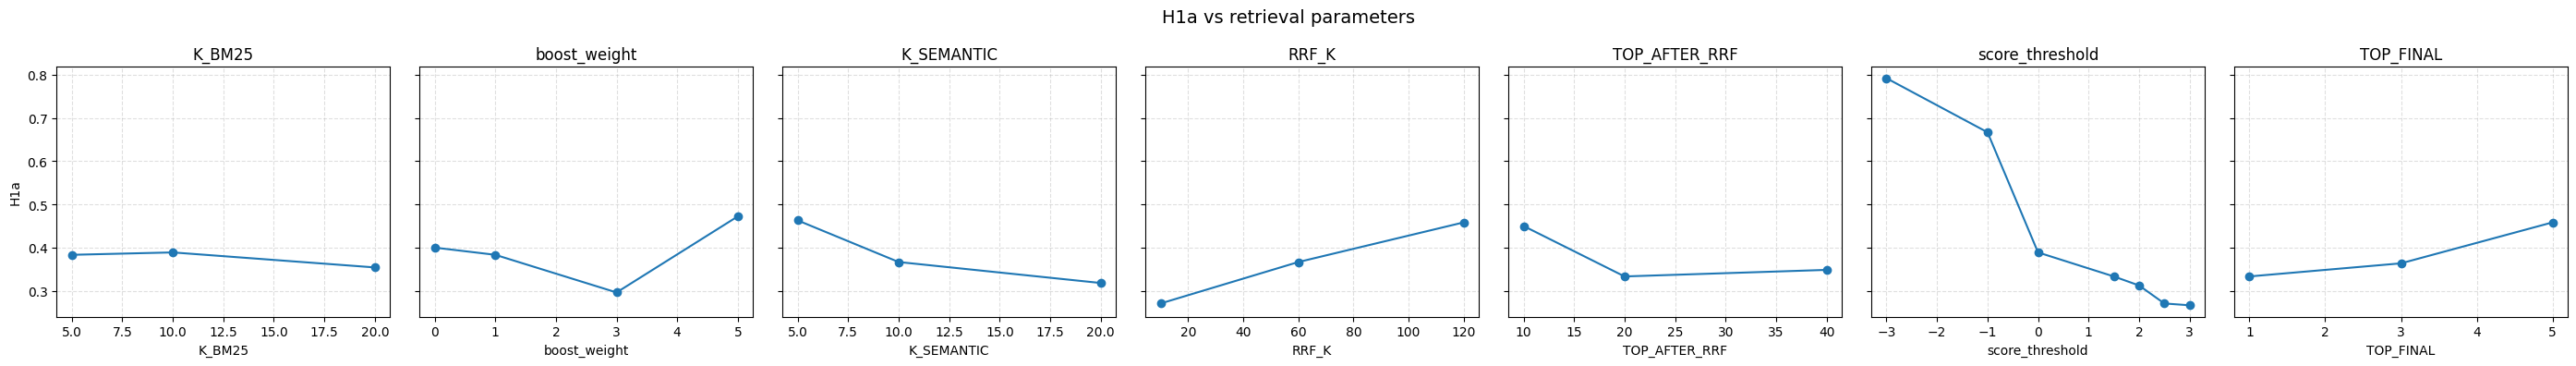

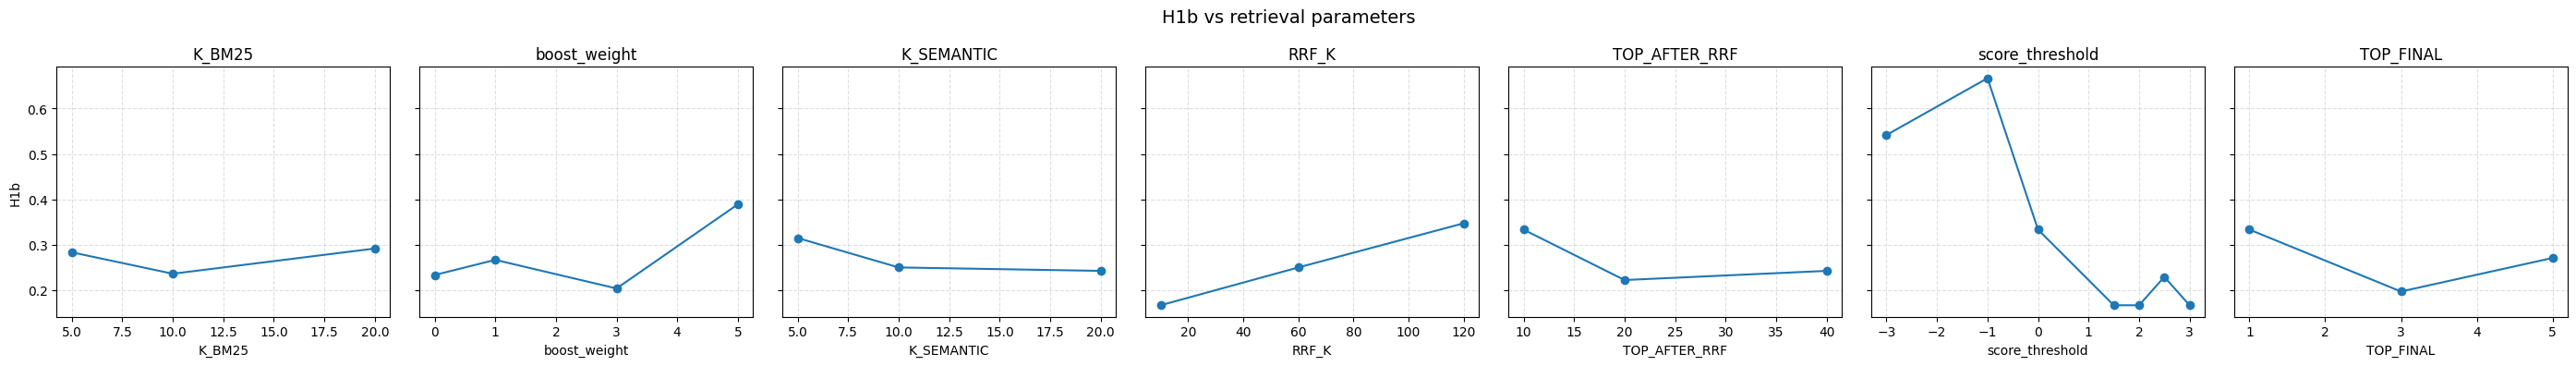

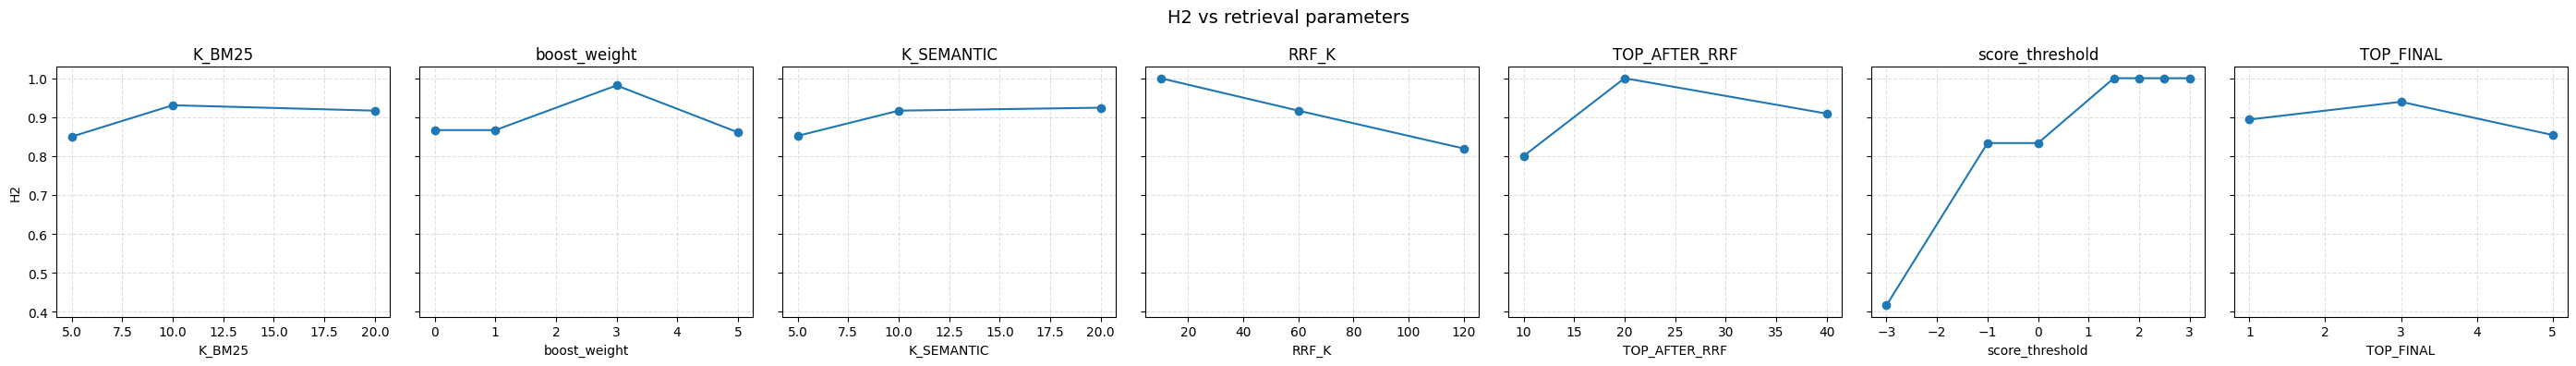

In [80]:
# Plot 3 figures: H1a, H1b, H2 vs each parameter to show main effect
param_names = [
    "K_BM25",
    "boost_weight",
    "K_SEMANTIC",
    "RRF_K",
    "TOP_AFTER_RRF",
    "score_threshold",
    "TOP_FINAL",
]

def plot_metric_vs_params(df, metric: str):
    n_params = len(param_names)
    fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4), sharey=True)

    if n_params == 1:
        axes = [axes]

    for ax, param in zip(axes, param_names):
        grouped = df.groupby(param)[metric].mean().sort_index()
        ax.plot(grouped.index, grouped.values, marker="o")
        ax.set_title(param)
        ax.set_xlabel(param)
        ax.grid(True, linestyle="--", alpha=0.4)

    axes[0].set_ylabel(metric)
    fig.suptitle(f"{metric} vs retrieval parameters", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_metric_vs_params(df_results, "H1a")
plot_metric_vs_params(df_results, "H1b")
plot_metric_vs_params(df_results, "H2")


The visualizations illustrate how the retrieval system’s performance metrics—H1a (Success@K ≥ 1), H1b (Top-1 Accuracy), and H2 (Hallucination Rejection Accuracy)—vary as individual retrieval parameters are adjusted. Each panel contains seven subplots corresponding to the seven parameters in the retrieval pipeline, and each point in these subplots represents the average metric value across all experimental configurations that share the same parameter value. This provides a high-level, marginal analysis of parameter influence, which is particularly valuable for diagnosing sensitivity and identifying highly impactful hyperparameters.

The plots show that score_threshold emerges as the dominant parameter

the plots reveal main effects but not interaction effects.

# plotly plots shows general H1a , H2a,H2

In [81]:
import plotly.express as px
import pandas as pd

df = df_results.copy()

# -----------------------------------------
# Rename metrics before melting (cleanest)
# -----------------------------------------
rename_map = {
    "H1a": "H1a: success@k",
    "H1b": "H1b: top-1 retrieval",
    "H2": "H2: unanswerable queries"
}

df = df.rename(columns=rename_map)

df_long = df.melt(
    id_vars=["K_BM25", "boost_weight", "K_SEMANTIC", "RRF_K", 
             "TOP_AFTER_RRF", "score_threshold", "TOP_FINAL"],
    value_vars=list(rename_map.values()),
    var_name="Metric",
    value_name="Score"
)

# -------------------------
# Rank within each metric
# -------------------------
df_long["Rank"] = df_long.groupby("Metric")["Score"].rank(method="first") - 1
df_long = df_long.sort_values(["Metric", "Rank"])

# -------------------------
# Build hover text
# -------------------------
df_long["hover_text"] = (
    "Metric: " + df_long["Metric"].astype(str) +
    "<br>Score: " + df_long["Score"].round(3).astype(str) +
    "<br><br><b>Config:</b>" +
    "<br>K_BM25: " + df_long["K_BM25"].astype(str) +
    "<br>boost_weight: " + df_long["boost_weight"].astype(str) +
    "<br>K_SEMANTIC: " + df_long["K_SEMANTIC"].astype(str) +
    "<br>RRF_K: " + df_long["RRF_K"].astype(str) +
    "<br>TOP_AFTER_RRF: " + df_long["TOP_AFTER_RRF"].astype(str) +
    "<br>score_threshold: " + df_long["score_threshold"].astype(str) +
    "<br>TOP_FINAL: " + df_long["TOP_FINAL"].astype(str)
)

fig = px.line(
    df_long,
    x="Rank",
    y="Score",
    color="Metric",
    markers=True,
    hover_name="Metric",
    hover_data={"hover_text": True, "Score": False},
)

# Attach hover text
fig.update_traces(hovertemplate="%{customdata[0]}")
fig.for_each_trace(
    lambda t: t.update(
        customdata=df_long[df_long["Metric"] == t.name][["hover_text"]].to_numpy()
    )
)

fig.update_layout(
    title="Ranked Retrieval Metrics",
    xaxis_title="Rank (Low → High)",
    yaxis_title="Score",
    height=600
)

fig.show()


# Parameter Overlap Heatmap 

This visually shows where each parameter’s good-performing ranges overlap across H1a, H1b, H2.

Heatmap meaning:

    Rows = parameters

    Columns = parameter values

    Colors = number of metrics for which that value is “high-performing”
    (0 = bad, 1 = good for one metric, 2 = good for two metrics, 3 = perfect overlap)

This gives you an immediate picture of where all metrics agree.

In [82]:
import pandas as pd
import plotly.express as px

# thresholds you used
h1a_thr = 0.8
h1b_thr = 0.6
h2_thr = 0.8

df = df_results.copy()

metrics = {
    "H1a": df["H1a"] > h1a_thr,
    "H1b": df["H1b"] > h1b_thr,
    "H2": df["H2"] > h2_thr,
}

param_cols = ["K_BM25", "boost_weight", "K_SEMANTIC", "RRF_K",
              "TOP_AFTER_RRF", "score_threshold", "TOP_FINAL"]

# Build (parameter value → how many metrics consider it high-performing)
records = []

for param in param_cols:
    values = df[param].unique()
    for v in sorted(values):
        count = (
            metrics["H1a"][df[param] == v].any().astype(int) +
            metrics["H1b"][df[param] == v].any().astype(int) +
            metrics["H2"][df[param] == v].any().astype(int)
        )
        records.append({"parameter": param, "value": v, "overlap_score": count})

heat_df = pd.DataFrame(records)

fig = px.imshow(
    heat_df.pivot(index="parameter", columns="value", values="overlap_score"),
    color_continuous_scale="Blues",
    aspect="auto",
    title="Overlap Heatmap of High-Performing Parameter Values<br>(Darker = Works for More Metrics)"
)

fig.update_layout(height=600)
fig.show()


The overlap heatmap visualizes the robustness of parameter values across three retrieval performance metrics (H1a, H1b, H2). 

 Darker regions indicate values that consistently satisfy performance thresholds, while lighter areas reflect configurations that work for only one metric or none.


# Explore more about "score_threshold"+ "boost_weight"

In [86]:
#Parameter space for tuning 
param_space = {
    "K_BM25":          [5],
    "boost_weight":    [0.0, 1.0, 2,0, 3.0, 4.0, 5.0, 6.0],
    "K_SEMANTIC":      [5],
    "RRF_K":           [100],
    "TOP_AFTER_RRF":   [5],
    "score_threshold": [-3, -2, -1,-0.5, 0, 0.5, 1,1.5, 2.0],
    "TOP_FINAL":       [3]
}

from itertools import product

print("Current param_space:")
for k, v in param_space.items():
    print(f"  {k}: {v}")

param_items = list(param_space.items())
configs = []
for values in product(*[vals for _, vals in param_items]):
    cfg = {param_items[i][0]: values[i] for i in range(len(values))}
    configs.append(cfg)

print("Total combinations:", len(configs))
print("First (and only?) config:", configs[0])

Current param_space:
  K_BM25: [5]
  boost_weight: [0.0, 1.0, 2, 0, 3.0, 4.0, 5.0, 6.0]
  K_SEMANTIC: [5]
  RRF_K: [100]
  TOP_AFTER_RRF: [5]
  score_threshold: [-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.0]
  TOP_FINAL: [3]
Total combinations: 72
First (and only?) config: {'K_BM25': 5, 'boost_weight': 0.0, 'K_SEMANTIC': 5, 'RRF_K': 100, 'TOP_AFTER_RRF': 5, 'score_threshold': -3, 'TOP_FINAL': 3}


In [ ]:
df_results = run_full_grid_search(
    param_space=param_space,
    test_set=test_set,
    save_path="grid_search_results_b.csv"
)
df_results

Total combinations: 72


Grid Search:   0%|          | 0/72 [00:00<?, ?it/s]2025-11-19 22:20:04.547 | INFO     | retrieval.retrieval:retrieve_top_k:370 - 🔍 Starting retrieval pipeline for query: 'How to import data from Excel or CSV into JASP?'
2025-11-19 22:20:04.550 | INFO     | retrieval.retrieval:load_docs_for_bm25:199 - 📄 Loaded 16 chunks from /Users/ywxiu/jasp-multimodal-rag/data/processed/chunks/github_RegressionLinearBayesian.json
2025-11-19 22:20:04.551 | INFO     | retrieval.retrieval:load_docs_for_bm25:199 - 📄 Loaded 33 chunks from /Users/ywxiu/jasp-multimodal-rag/data/processed/chunks/github_RegressionLogistic.json
2025-11-19 22:20:04.552 | INFO     | retrieval.retrieval:load_docs_for_bm25:199 - 📄 Loaded 43 chunks from /Users/ywxiu/jasp-multimodal-rag/data/processed/chunks/video_Introduction_to_JASP_APRaBFC2lEQ_chunks.json
2025-11-19 22:20:04.553 | INFO     | retrieval.retrieval:load_docs_for_bm25:199 - 📄 Loaded 58 chunks from /Users/ywxiu/jasp-multimodal-rag/data/processed/chunks/github_MixedModel

# Plot: Metrics vs. Score Threshold for Each Boost Weight

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure df_results is loaded
# df_results = pd.read_csv("grid_search_results.csv")

# Unique boost weights and thresholds
boost_values = sorted(df_results["boost_weight"].unique())
threshold_values = sorted(df_results["score_threshold"].unique())

# Create plots
for bw in boost_values:
    df_bw = df_results[df_results["boost_weight"] == bw].sort_values("score_threshold")

    plt.figure(figsize=(8, 5))

    # Plot each metric as a separate line
    plt.plot(df_bw["score_threshold"], df_bw["H1a"], marker="o", label="H1a (Success@k)")
    plt.plot(df_bw["score_threshold"], df_bw["H1b"], marker="o", label="H1b (Top-1)")
    plt.plot(df_bw["score_threshold"], df_bw["H2"],  marker="o", label="H2 (Unanswerable)")

    plt.title(f"Metrics vs Score Threshold (boost_weight = {bw})")
    plt.xlabel("Score Threshold")
    plt.ylabel("Metric Value")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()
